In [9]:
import numpy as np
import joypy
from matplotlib import pyplot as plt
from matplotlib import cm

from scipy import ndimage as ndi
from scipy.spatial import distance

from skimage import io
from skimage.color import rgb2gray
from scipy import ndimage
from skimage import filters
from skimage.morphology import disk, ball

from PIL import Image, ImageDraw, ImageFilter,ImageOps
import copy
import cv2

%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [7]:
grain1_name='Ultra_Co6_2-040.jpg'
grain2_name='Ultra_Co11-2.jpg'
grain3_name='Ultra_Co25-1.jpg'

path='images'

grain1_pil=Image.open(path+'/'+grain1_name)
grain2_pil=Image.open(path+'/'+grain2_name)
grain3_pil=Image.open(path+'/'+grain3_name)

In [10]:
def img_show(image,N=20,cmap=plt.cm.nipy_spectral):
    
    plt.figure(figsize=(N,N))
    plt.axis('off')
    plt.imshow(image,cmap=cmap)
    plt.show()

def imdivide(image,side):
    
    width,height = image.size
    sides={'left':0,'right':1}
    shape=[(0,0,width//2,height),(width//2,0,width,height)]
    return image.crop(shape[sides[side]])

def combine(image,k=0.5,N=20): 
    left_img=imdivide(image,'left')
    right_img=imdivide(image,'right')

    l=k
    r=1-l
    gray=np.array(left_img)*l
    gray+=np.array(right_img)*r
    gray=gray.astype('uint8')
    return gray

def do_otsu(img,N=20):
    image=rgb2gray(img)
    
    global_thresh=filters.threshold_otsu(image)
    binary_global = image > global_thresh
    
    return binary_global

## Выделение пустот

denoised=mean_filter(image)

binary=otsu(denoised)

grad=gradient(binary)

bin_grad=-binary+grad

In [11]:
combined1=combine(grain1_pil,0.5,10)
combined2=combine(grain2_pil,0.5,10)
combined3=combine(grain3_pil,0.5,10)

denoised1 = filters.rank.median(combined1, disk(3))
denoised2 = filters.rank.median(combined2, disk(3))
denoised3 = filters.rank.median(combined3, disk(3))

binary1=do_otsu(denoised1).astype('uint8')
binary2=do_otsu(denoised2).astype('uint8')
binary3=do_otsu(denoised3).astype('uint8')

grad1 = filters.rank.gradient(binary1, disk(1))
grad2 = filters.rank.gradient(binary2, disk(1))
grad3 = filters.rank.gradient(binary3, disk(1))

# у зерен значение пикселя - 0, у тела пустоты - 1, у границы пустоты - 2
bin_grad1=1-binary1+grad1
bin_grad2=1-binary2+grad2
bin_grad3=1-binary3+grad3

image1=(bin_grad1>0).astype('uint8')*255
image2=(bin_grad2>0).astype('uint8')*255
image3=(bin_grad3>0).astype('uint8')*255

C:\Users\Администратор\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:27: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


In [ ]:
#io.imsave('bin_grad.png',image)

## Маркировка углов

http://espressocode.top/python-corner-detection-with-shi-tomasi-corner-detection-method-using-opencv/

classes - каждому пикселю дается свой класс, по картинке гуляет матрица свертки

In [12]:
def mark_corners(image):
    image=copy.copy(image)
    corners = cv2.goodFeaturesToTrack(image, 1000000, 0.01, 10)

    corners = np.int0(corners)
    print('number of corners: ',len(corners))
    for i in corners:
        x, y = i.ravel()
        cv2.circle(image, (x, y), 3, 255, -1)
    x=copy.copy(corners[:,0,1])
    y=copy.copy(corners[:,0,0])
    corners[:,0,0],corners[:,0,1]=x,y
    return image,corners.astype('int64')

def mark_classes(image):
    classes = filters.rank.gradient(image, disk(1)) < 250
    classes,num = ndi.label(classes)
    print('number of classes:',num)
    return classes,num

In [13]:
grain1_marked,grain1_corners=mark_corners(image1)
grain2_marked,grain2_corners=mark_corners(image2)
grain3_marked,grain3_corners=mark_corners(image3)

grain1_classes,class1_num=mark_classes(image1)
grain2_classes,class2_num=mark_classes(image2)
grain3_classes,class3_num=mark_classes(image3)

number of corners:  321
number of corners:  2727
number of corners:  6174
number of classes: 196
number of classes: 342
number of classes: 1244


## Дадим каждой вершине привязку к пустоте

In [14]:
def join_corners2classes(classes,classes_num,corners,max_corners_per_class):

    shape=(classes_num+1,max_corners_per_class)
    nodes=np.zeros(shape,dtype='int64')
    r=2
    num1=0
    num0=0
    for i,corner in enumerate(corners):
        x=corner[0][0]
        y=corner[0][1]
        cls=classes[x,y]
        real_cls=0
        flag=True
        x_lin=range(x-r,x+r)
        y_lin=range(y-r,y+r)
        while flag:
            for xi in range(x-r,x+r):
                for yi in y_lin:
                    if classes[xi,yi]!=0 and classes[xi,yi]!=1 and classes[xi,yi]!=2:
                        real_cls=classes[xi,yi]
                        flag=False
                    elif yi==y_lin[-1] and xi==x_lin[-1]:
                        flag=False
                        
        
        index=np.where(nodes[real_cls]==0)[0][0]
        nodes[real_cls,index]=i
        nodes[real_cls,-1]+=1 # вносит погрешность


    return nodes

In [15]:
nodes1=join_corners2classes(grain1_classes,
                             class1_num,
                             grain1_corners,
                             100)

nodes2=join_corners2classes(grain2_classes,
                             class2_num,
                             grain2_corners,
                             200)

nodes3=join_corners2classes(grain3_classes,
                             class3_num,
                             grain3_corners,
                             600)


## Подсчитаем количество углов у пустот

In [16]:
def show_corners_classes(nodes,classes,N=2000): 
    node_corner_numbers=np.zeros((classes.shape[0],1))
    for i,node in enumerate(nodes):
        for corner in node:
            if corner:
                node_corner_numbers[i]+=1

    std=node_corner_numbers.std(axis=0)[0]
    mean=node_corner_numbers.mean(axis=0)[0]

    print('std: ',round(std,3))
    print('mean: ',round(mean,3))
    print('number of classes: ',classes.shape[0])
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_ylabel('Количество углов у пустоты',size=20)
    ax.set_xlabel('Порядковый номер пустоты',size=20)
    plt.plot(node_corner_numbers[:N])

std:  6.482
mean:  4.4
number of classes:  1671


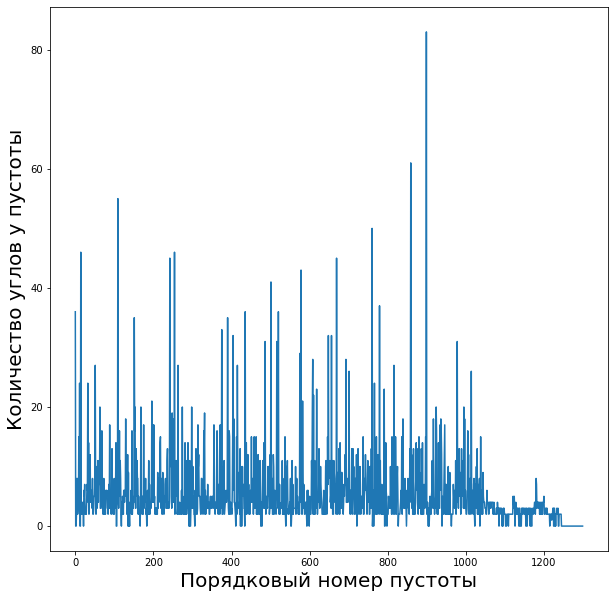

In [96]:
N=1300
show_corners_classes(nodes3,grain3_classes,N)

## Подсчитаем количество пустот, в которые входит угол

In [17]:
def show_classes_corners(nodes,corners,N=2000,N1=5):   
    corner_distr=np.zeros((corners.shape[0]))
    
    for i in range(corners.shape[0]):
        for node in nodes:
            node_len=node[-1]
            if i in node[:node_len]:
                corner_distr[i]+=1
                
    std=corner_distr.std(axis=0)
    mean=corner_distr.mean(axis=0)

    print('std: ',std)
    print('mean: ',mean)
    fig, ax = plt.subplots(figsize=(N1,N1))
    ax.set_ylabel('Количество вхождений в пустоту',size=20)
    ax.set_xlabel('Порядковый номер угла',size=20)
    plt.plot(corner_distr[:N])
    plt.show()
    return corner_distr

std:  0.0
mean:  1.0


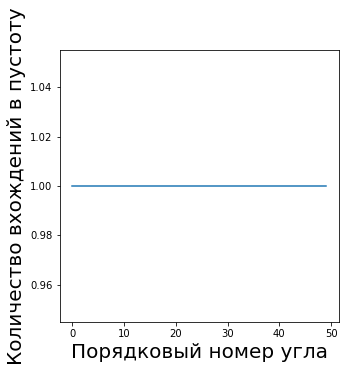

In [119]:
k=50
#corner_distr1=show_classes_corners(nodes1,grain1_corners,k)
corner_distr2=show_classes_corners(nodes2,grain2_corners,k)
#corner_distr3=show_classes_corners(nodes3,grain3_corners,k)

## Соединим углы пустоты по периметру

https://ru.wikipedia.org/wiki/Алгоритм_Брезенхэма
https://ru.wikibooks.org/wiki/Реализации_алгоритмов/Алгоритм_Брезенхэма

In [63]:
def mean_pixel(image,max_dist,point1,point2,R,b):
    val=0
    num=0
    image=rgb2gray(image)
    x1,y1=point1[0],point1[1]
    x2,y2=point2[0],point2[1]

    # идем всегда из х1 в х2, сверху вниз
    if x1>x2:
        x1,y1,x2,y2=x2,y2,x1,y1

    k1=x2-x1
    k2=y2-y1
    
    xi=a2*R/(k1**2+k2**2)**0.5
    yi=a1*R/(k1**2+k2**2)**0.5
    
    a1,a2=(x1+xi),(y1+yi)
    b1,b2=(x1-xi),(y1-yi)
    
    c1,c2=(x2+xi),(y2+yi)
    d1,d2=(x2-xi),(y2-yi)
    
    rect_side=distance.euclidean((a1,a2),(b1,b2))
    x_lin=range(x1,x2)
    
    left_points=np.zeros((rect_side,2))
    right_points=np.zeros((rect_side,2))
    # неверно
    # не учитывается, если на один х два значения у
    # нужна такая штука https://ru.wikipedia.org/wiki/Алгоритм_Брезенхэма
    rect_side_x_lin=range(a1,b1)
    
    # a -> b
    # c -> d
    for i,xi in enumerate(rect_side_x_lin):
        left_point=round(((xi-a1)/(b1-a1))*(b2-a2)+a2)
        right_point=round(((xi-c1)/(d1-c1))*(d2-c2)+c2)
        left_points[i]=(xi,left_point)
        right_points[i]=(xi,right_point)

    
    
    # a -> c
    # b -> d

    lines=np.zeros((2*R+1,points_dist,2))
    
    for i,line in enumerate(lines):
        
        x_lin=range(x1,x2)
    # проведем линию и сохраним ее координаты
    for xi in x_lin:
        y_lin.append(round(((xi-x1)/(x2-x1))*(y2-y1)+y1))
    # координатная ось повернута на -90 градусов
    # новый х=-y, новый y=x

    x_lin=np.array(x_lin,dtype='int64')
    y_lin=np.array(y_lin,dtype='int64')
    r=0
    for xi,yi in zip(y_lin,x_lin):
        for x in range(xi-r,xi+r):
            for y in range(yi-r,yi+r):

                val+=image[y,x]
                num+=1
    
    if num!=0 and val!=0:
        pix_mean=(val/num)/255
        
        mean=1-abs(pix_mean-0.5)*2
        dist=1-distance.euclidean(point1,point2)/max_dist
        
        f=abs(1-(1+b*b)*mean*dist/(mean*b*b+dist))
    else:
        f=1
        
    return f

In [19]:
def estimate_edges(image,max_dist,node,corners,b,position=0,radius=2):
    # вычисление расстояния и среднего значения между 
    # точкой с индексом posion и остальными точками пустоты
    v1=node[position]
    vals=np.zeros((len(node),2))
    if v1!=0:
        for i,v2 in enumerate(node):

            if v2!=0 and v1!=v2  :
                vals[i,0]=v2
                point1=corners[v1]
                point2=corners[v2]
                k=mean_pixel(image,max_dist,point1[0],point2[0],radius,b=b)
                vals[i,1]=k
    return vals
        

In [21]:
def max_dist_points(node,corners):
    max_dist=0
    for v1 in node:
        for v2 in node:
            if v1!=v2:
                point1=corners[v1]
                point2=corners[v2]
                dist=distance.euclidean(point1,point2)
                if dist>max_dist:
                    max_dist=dist
                
    return max_dist

In [29]:
def sort_perimetr(image,nodes,corners,b,radius=5):
    new_nodes=np.zeros(nodes.shape,dtype='int64')
    
    # проходим по каждой пустоте
    for i,orig_node in enumerate(nodes):
    # node - пустота
        v1_index=0
        v1=orig_node[v1_index] # фиксируем первый угол и затем будем считать относительно него
        step=1
        new_nodes[i,0]=v1
        flag=True
        orig_node_len=orig_node[-1]
        node=list(copy.copy(orig_node[:orig_node_len]))
        max_dist=max_dist_points(node,corners)
        print('i=',i, ' max=',orig_node.shape[0])
      #  print('-------------')

        if v1!=0 and len(node)>1:
            while flag:

                vals=estimate_edges(image,max_dist,node,corners,position=v1_index,radius=radius,b=b)
                non_zero_indeces=np.where((vals[:,0][:orig_node_len]!=0) )[0]
                vals=vals[non_zero_indeces]
                min_val=vals.min(axis=0)[1]
                
              #  print('min_val',min_val)
                v2_vals_index=np.where(vals[:,1]==min_val )[0][0]
                v2=vals[v2_vals_index][0]
                v2_index=np.where(node==v2)[0][0]

                new_nodes[i,step]=v2
                node.pop(v1_index)
                
                v1=v2
                v2_index=node.index(v2)
                v1_index=v2_index

                
                step+=1
                if step==orig_node_len:
                    flag=False
               
        else:
            continue
        new_nodes[i,-1]= orig_node_len
    return new_nodes

In [136]:
image=image2
N=212
max_dist=80
# 46
radius=6
img=Image.fromarray(np.uint8(cm.gist_earth(image)*255))
image = ImageOps.expand(img,border=radius,fill='black')
image=np.array(image)

#vals=estimate_edges(image,nodes[N],corners,position=position,radius=5)

#img=draw_edges(image,position,node.astype('int64'),vals,corners,max_dist)
i=4
b=1
new_nodes=sort_perimetr(image,nodes2[:50],grain2_corners,radius=radius,b=b)

#img_show(img,cmap='gray',N=12)
#io.imsave('vals.png',img)

i= 0  max= 200


C:\Users\Администратор\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  after removing the cwd from sys.path.


i= 1  max= 200
i= 2  max= 200
i= 3  max= 200
i= 4  max= 200
i= 5  max= 200
i= 6  max= 200
i= 7  max= 200
i= 8  max= 200
i= 9  max= 200
i= 10  max= 200
i= 11  max= 200
i= 12  max= 200
i= 13  max= 200
i= 14  max= 200
i= 15  max= 200
i= 16  max= 200
i= 17  max= 200
i= 18  max= 200
i= 19  max= 200
i= 20  max= 200
i= 21  max= 200
i= 22  max= 200
i= 23  max= 200
i= 24  max= 200
i= 25  max= 200
i= 26  max= 200
i= 27  max= 200
i= 28  max= 200
i= 29  max= 200
i= 30  max= 200
i= 31  max= 200
i= 32  max= 200
i= 33  max= 200
i= 34  max= 200
i= 35  max= 200
i= 36  max= 200
i= 37  max= 200
i= 38  max= 200
i= 39  max= 200
i= 40  max= 200
i= 41  max= 200
i= 42  max= 200
i= 43  max= 200
i= 44  max= 200
i= 45  max= 200
i= 46  max= 200
i= 47  max= 200
i= 48  max= 200
i= 49  max= 200


In [36]:
def draw_edges(image,nodes,corners,color=(51,51,51)):
    new_image=copy.copy(image)
    
    im = Image.fromarray(np.uint8(cm.gist_earth(new_image)*255))
    draw = ImageDraw.Draw(im)
    for j,node in enumerate(nodes):
        if len(node)>1:
         #   print('i=',j)
        #    print(node)
            point1=corners[node[0]][0]
            x1,y1=point1[0],point1[1]
            x_start,y_start=point1[0],point1[1]
            r1=5
            r=3
            draw.ellipse((y1-r1,x1-r1,y1+r1,x1+r1), fill=color, width=10)
            len_node=node[-1]
       #     print(node[:len_node])
            for i,point in enumerate(node[: len_node]):
                point2=corners[point][0]
                x2,y2=point2[0],point2[1]

                draw.ellipse((y2-r,x2-r,y2+r,x2+r), fill=color, width=4)
                draw.line((y1,x1,y2,x2), fill=color, width=4)
                x1,y1=x2,y2
                
            draw.line((y_start,x_start,y1,x1), fill=(100,100,100), width=4)
        else:
            continue

    img=np.array(im)
    io.imsave('vals.png',img)

    return  img
        

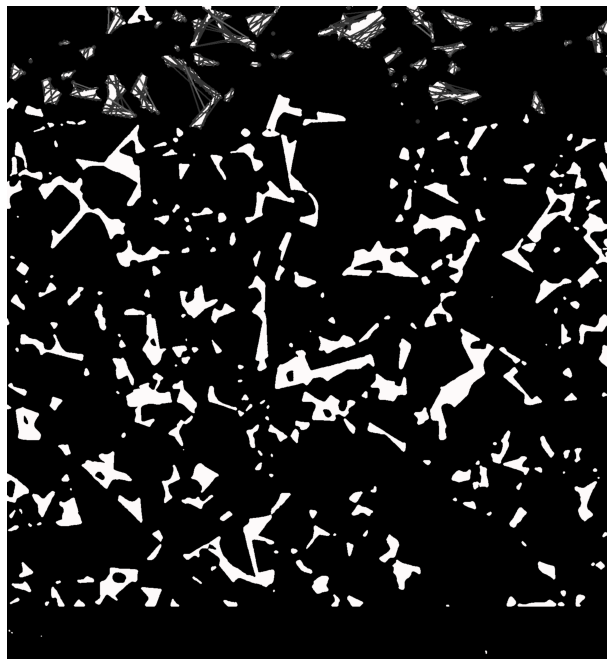

In [137]:
img2=draw_edges(image2,new_nodes[1:50],grain2_corners)
img_show(img2,cmap='gray',N=12)
io.imsave('vals.png',img2)

In [61]:
%%cython -a
cimport numpy as np
import numpy as np

import copy
from scipy.spatial import distance
cimport cython

from libc.time cimport time
from libc.math cimport exp

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
@cython.cdivision(True)
cdef max_dist_points(np.ndarray[np.int, ndim=2, negative_indices=False,mode='c'] node,
                     np.ndarray[np.int, ndim=2, negative_indices=False,mode='c'] corners):
    cdef: 
        double max_dist=0
        np.int v1
        np.int v2
        np.ndarray[np.int, ndim=1, negative_indices=False,mode='c'] point1
        np.ndarray[np.int, ndim=1, negative_indices=False,mode='c'] point2
        double dist
    for v1 in node:
        for v2 in node:
            if v1!=v2:
                point1=corners[v1]
                point2=corners[v2]
                dist=distance.euclidean(point1,point2)
                if dist>max_dist:
                    max_dist=dist
                
    return max_dist

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
@cython.cdivision(True)
cdef estimate_edges(np.ndarray[np.int, ndim=2, negative_indices=False,mode='c'] image,
                    float max_dist,
                    np.ndarray[np.int, ndim=1, negative_indices=False,mode='c'] node,
                    np.ndarray[np.int, ndim=2, negative_indices=False,mode='c'] corners,
                    float b,
                    int position,
                    int radius):
    # вычисление расстояния и среднего значения между 
    # точкой с индексом posion и остальными точками пустоты
    cdef:
        np.int v1=node[position]
        np.int v2,i
        np.ndarray vals = np.zeros((len(node),2), dtype=np.double)
        np.ndarray[np.int, ndim=1, negative_indices=False,mode='c'] point1
        np.ndarray[np.int, ndim=1, negative_indices=False,mode='c'] point2
        
    if v1!=0:
        for i,v2 in enumerate(node):

            if v2!=0 and v1!=v2  :
                vals[i,0]=v2
                point1=corners[v1]
                point2=corners[v2]
                k=mean_pixel(image,max_dist,point1[0],point2[0],radius,b=b)
                vals[i,1]=k
    return vals
        
def mean_pixel(image,max_dist,point1,point2,r,b):
    val=0
    num=0
    x1,y1=point1[0],point1[1]
    x2,y2=point2[0],point2[1]

    # идем всегда из х1 в х2, сверху вниз
    if x1>x2:
        x1,y1,x2,y2=x2,y2,x1,y1

    y_lin=[]
    x_lin=range(x1,x2)
    # проведем линию и сохраним ее координаты
    for xi in x_lin:
        y_lin.append(round(((xi-x1)/(x2-x1))*(y2-y1)+y1))
    # координатная ось повернута на -90 градусов
    # новый х=-y, новый y=x

    x_lin=np.array(x_lin,dtype='int64')
    y_lin=np.array(y_lin,dtype='int64')
    for xi,yi in zip(y_lin,x_lin):
        for x in range(xi-r,xi+r):
            for y in range(yi-r,yi+r):

                val+=image[y,x]
                num+=1
    if num!=0 and val!=0:
        pix_mean=(val/num)/255
        
        mean=1-abs(pix_mean-0.5)*2
        dist=1-distance.euclidean(point1,point2)/max_dist
        
        f=abs(1-(1+b*b)*mean*dist/(mean*b*b+dist))
    else:
        f=1
        
    return f

def sort_perimetr(image,nodes,corners,b,radius=5):
    new_nodes=np.zeros(nodes.shape,dtype='int64')
    
    # проходим по каждой пустоте
    for i,orig_node in enumerate(nodes):
    # node - пустота
        v1_index=0
        v1=orig_node[v1_index] # фиксируем первый угол и затем будем считать относительно него
        step=1
        new_nodes[i,0]=v1
        flag=True
        orig_node_len=orig_node[-1]
        node=list(copy.copy(orig_node[:orig_node_len]))
        max_dist=max_dist_points(node,corners)
        print('i=',i, ' max=',orig_node.shape[0])
      #  print('-------------')

        if v1!=0 and len(node)>1:
            while flag:

                vals=estimate_edges(image,max_dist,node,corners,position=v1_index,radius=radius,b=b)
                non_zero_indeces=np.where((vals[:,0][:orig_node_len]!=0) )[0]
                vals=vals[non_zero_indeces]
                min_val=vals.min(axis=0)[1]
                
              #  print('min_val',min_val)
                v2_vals_index=np.where(vals[:,1]==min_val )[0][0]
                v2=vals[v2_vals_index][0]
                v2_index=np.where(node==v2)[0][0]

                new_nodes[i,step]=v2
                node.pop(v1_index)
                
                v1=v2
                v2_index=node.index(v2)
                v1_index=v2_index

                
                step+=1
                if step==orig_node_len:
                    flag=False
               
        else:
            continue
        new_nodes[i,-1]= orig_node_len
    return new_nodes